In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np
import trees
from trees.ddt import DirichletDiffusionTree, Inverse, GaussianLikelihoodModel
from trees.mcmc import MetropolisHastingsSampler
from trees.util import plot_tree, plot_tree_2d
import mpld3
import seaborn as sns
sns.set_style('white')
from tqdm import tqdm
from sklearn.decomposition import PCA
import cPickle as pickle

[[ 4.68476056 -0.66790894]
 [-0.66790894  1.02095123]]


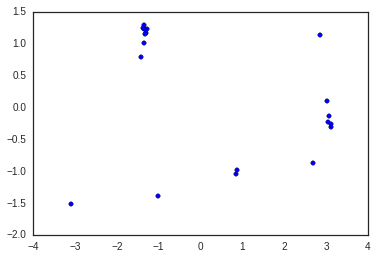

In [9]:
X, y = trees.data.load('zoo')
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X += np.random.normal(scale=0.05, size=X.shape)
idx = xrange(20)
X = X[idx]
print np.cov(X.T)
N, D = X.shape
scatter(*X.T);
with open('../scripts/zoo.tree', 'rb') as fp:
    master_tree = pickle.load(fp).induced_subtree(idx)
master_constraints = list(master_tree.generate_constraints())
train_constraints, test_constraints = master_constraints[:100], master_constraints[100:]

INFO:root:Compiling <Inverse> object...
INFO:root:Done compiling <Inverse> object.
INFO:root:Compiling <GaussianLikelihoodModel> object...
INFO:root:Done compiling <GaussianLikelihoodModel> object.
INFO:root:Compiling <GaussianLikelihoodModel> object...
INFO:root:Done compiling <GaussianLikelihoodModel> object.


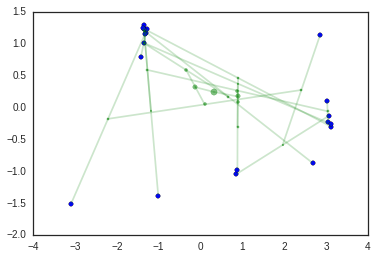

In [11]:
df = Inverse(c=1)

lm = GaussianLikelihoodModel(sigma=np.cov(X.T) / 4.0, sigma0=np.eye(D) / 2.0, mu0=X.mean(axis=0)).compile()
sampler = MetropolisHastingsSampler(DirichletDiffusionTree(df=df, likelihood_model=lm, constraints=[]), X)
sampler.initialize_assignments()

sampler2 = MetropolisHastingsSampler(DirichletDiffusionTree(df=df, likelihood_model=lm, constraints=train_constraints), X)
sampler2.initialize_assignments()

def iterate(n_iters):
    score, score2 = [], []
    for i in tqdm(xrange(n_iters)):
        sampler.sample()
        sampler2.sample()

        score.append(float(sampler.tree.score_constraints(test_constraints)) / len(test_constraints))
        score2.append(float(sampler2.tree.score_constraints(test_constraints)) / len(test_constraints))
    return score, score2

plot_tree_2d(sampler.tree, X)

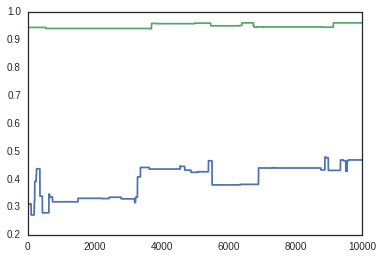

In [12]:
score, score2 = iterate(10000)
plot(score)
plot(score2)
#figure()
#plot_tree_2d(sampler.tree, X)

In [ ]:
fig = plot_tree(master_tree, mpld3=True, y=y)
mpld3.display()

In [8]:
float(sampler.tree.score_constraints(master_constraints)) / len(master_constraints)

1.0

In [ ]:
sampler.sample()
print float(sampler.tree.score_constraints(master_constraints)) / len(master_constraints)

In [ ]:
X[y.index('aardvark')]

In [ ]:
sampler.X